<a href="https://colab.research.google.com/github/arpa2568/Cataract-Classification/blob/main/CataractClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-lrw9ie5k
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-lrw9ie5k
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp37-none-any.whl size=33794 sha256=3199c9fa49c743f96b06ff1b1a7ce6460da09964dd4775014d71d62846fb3436
  Stored in directory: /tmp/pip-ephem-wheel-cache-dzz8zcm1/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [ ]:
pip install efficientnet

In [ ]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mi
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SEED = 42
EPOCHS = 2
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256
 
# cataract dataset
IMG_ROOT = r'/content/drive/MyDrive/InnoLabData/cataract/dataset/'
IMG_DIR = [IMG_ROOT+'1_normal', 
           IMG_ROOT+'2_cataract', 
           IMG_ROOT+'2_glaucoma', 
           IMG_ROOT+'3_retina_disease']
 
# ocular-disease-recognition dataset
OCU_IMG_ROOT = r'/content/drive/MyDrive/InnoLabData/ocular/ODIR-5K/ODIR-5K/Training Images/'
ocu_df = pd.read_excel(r'/content/drive/MyDrive/InnoLabData/ocular/ODIR-5K/ODIR-5K/data.xlsx')

In [ ]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
 
seed_everything(SEED)

In [ ]:
cat_df = pd.DataFrame(0, columns=['paths', 'cataract'], index=range(601))
 
filepaths = glob.glob(IMG_ROOT + '*/*')
 
 
for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    
    if filepath[0] == IMG_DIR[0]:    # normal
        cat_df.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[1]:  # cataract
        cat_df.iloc[i, 1] = 1
    elif filepath[0] == IMG_DIR[2]:  # glaucoma
        cat_df.iloc[i, 1] = 2
    elif filepath[0] == IMG_DIR[3]:  # retine_disease
        cat_df.iloc[i, 1] = 3
        
# only sample normal and cataract        
cat_df = cat_df.query('0 <= cataract < 2')
cat_df

,paths,cataract
0,/content/drive/MyDrive/InnoLabData/cataract/da...,1
1,/content/drive/MyDrive/InnoLabData/cataract/da...,1
2,/content/drive/MyDrive/InnoLabData/cataract/da...,1
3,/content/drive/MyDrive/InnoLabData/cataract/da...,1
4,/content/drive/MyDrive/InnoLabData/cataract/da...,1
...,...,...
596,/content/drive/MyDrive/InnoLabData/cataract/da...,0
597,/content/drive/MyDrive/InnoLabData/cataract/da...,0
598,/content/drive/MyDrive/InnoLabData/cataract/da...,0
599,/content/drive/MyDrive/InnoLabData/cataract/da...,0


In [ ]:
print('Number of normal and cataract images')
print(cat_df['cataract'].value_counts())

Number of normal and cataract images
0    300
1    100
Name: cataract, dtype: int64


In [ ]:
ocu_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [ ]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0
    
ocu_df['left_eye_cataract'] = ocu_df['Left-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))
ocu_df['right_eye_cataract'] = ocu_df['Right-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))

In [ ]:
le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_cataract']]\
        .rename(columns={'left_eye_cataract':'cataract'})
le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)


re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_cataract']]\
        .rename(columns={'right_eye_cataract':'cataract'})
re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)

In [ ]:
le_df.head()

,cataract,paths
0,1,/content/drive/MyDrive/InnoLabData/ocular/ODIR...
1,0,/content/drive/MyDrive/InnoLabData/ocular/ODIR...
2,0,/content/drive/MyDrive/InnoLabData/ocular/ODIR...
3,0,/content/drive/MyDrive/InnoLabData/ocular/ODIR...
4,0,/content/drive/MyDrive/InnoLabData/ocular/ODIR...


In [ ]:
re_df.head()

,cataract,paths
0,0,/content/drive/MyDrive/InnoLabData/ocular/ODIR...
1,0,/content/drive/MyDrive/InnoLabData/ocular/ODIR...
2,0,/content/drive/MyDrive/InnoLabData/ocular/ODIR...
3,0,/content/drive/MyDrive/InnoLabData/ocular/ODIR...
4,0,/content/drive/MyDrive/InnoLabData/ocular/ODIR...


In [ ]:
print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
0    3341
1     159
Name: cataract, dtype: int64

Number of right eye images
0    3346
1     154
Name: cataract, dtype: int64


In [ ]:
def downsample(df):
    df = pd.concat([
        df.query('cataract==1'),
        df.query('cataract==0').sample(sum(df['cataract']), 
                                       random_state=SEED)
    ])
    return df


le_df = downsample(le_df)
re_df = downsample(re_df)

print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
1    159
0    159
Name: cataract, dtype: int64

Number of right eye images
1    154
0    154
Name: cataract, dtype: int64


In [ ]:
ocu_df = pd.concat([le_df, re_df])
ocu_df.head()

,cataract,paths
0,1,/content/drive/MyDrive/InnoLabData/ocular/ODIR...
81,1,/content/drive/MyDrive/InnoLabData/ocular/ODIR...
103,1,/content/drive/MyDrive/InnoLabData/ocular/ODIR...
119,1,/content/drive/MyDrive/InnoLabData/ocular/ODIR...
253,1,/content/drive/MyDrive/InnoLabData/ocular/ODIR...


In [ ]:
df = pd.concat([cat_df, ocu_df], ignore_index=True)
df

,paths,cataract
0,/content/drive/MyDrive/InnoLabData/cataract/da...,1
1,/content/drive/MyDrive/InnoLabData/cataract/da...,1
2,/content/drive/MyDrive/InnoLabData/cataract/da...,1
3,/content/drive/MyDrive/InnoLabData/cataract/da...,1
4,/content/drive/MyDrive/InnoLabData/cataract/da...,1
...,...,...
1021,/content/drive/MyDrive/InnoLabData/ocular/ODIR...,0
1022,/content/drive/MyDrive/InnoLabData/ocular/ODIR...,0
1023,/content/drive/MyDrive/InnoLabData/ocular/ODIR...,0
1024,/content/drive/MyDrive/InnoLabData/ocular/ODIR...,0


In [ ]:
train_df, test_df = train_test_split(df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [ ]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cataract'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|██████████| 206/206 [01:42<00:00,  2.01it/s]


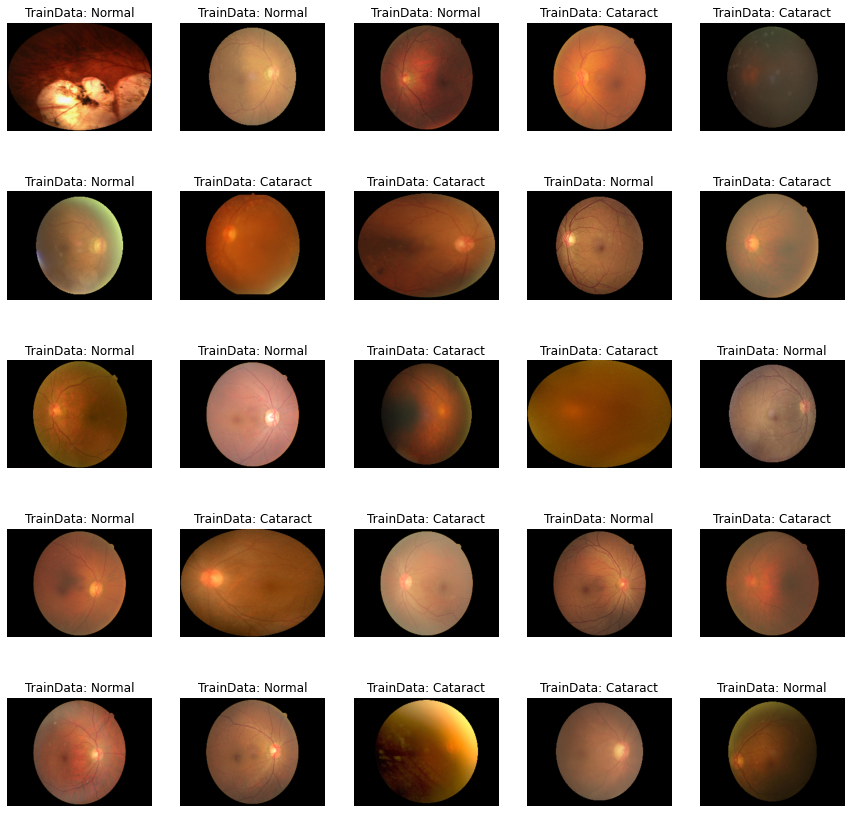

In [ ]:
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')
plt.show()

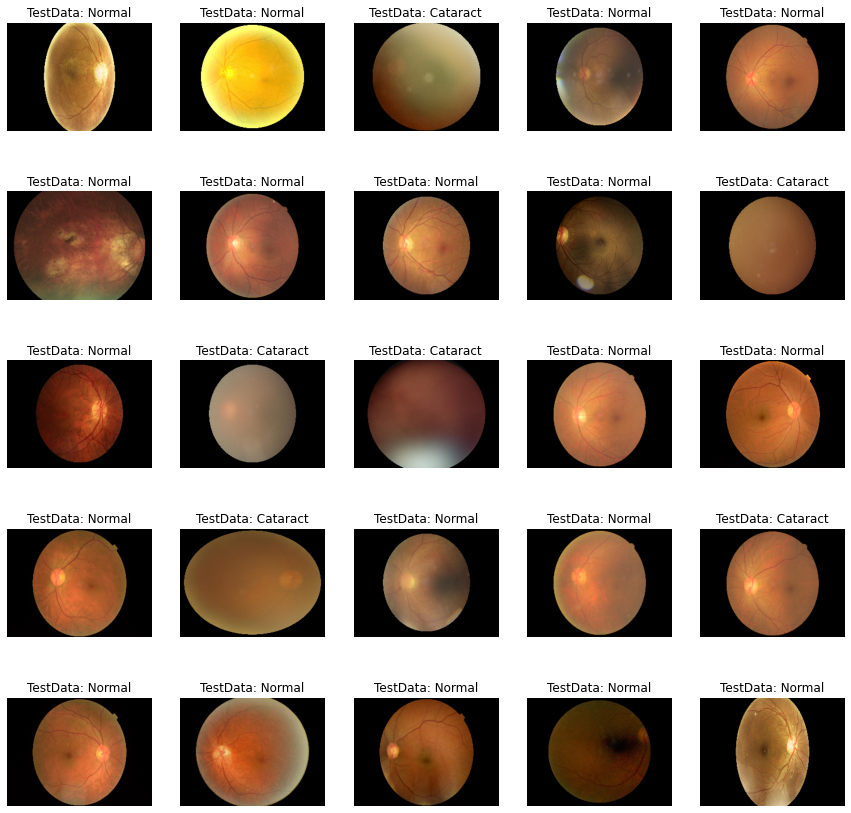

In [ ]:
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.show()

In [ ]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
get_custom_objects().update({'mish': Activation(mish)})

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model = Sequential()
model.add(Conv2D(16, kernel_size=3, padding='same', 
                 input_shape=input_shape, activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 256, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 256, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 256, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 85, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 85, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 85, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 85, 16)        2

In [ ]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/2
21/21 [==============================] - 77s 4s/step - loss: 0.6494 - accuracy: 0.7432 - val_loss: 0.5295 - val_accuracy: 0.7236
Epoch 2/2
21/21 [==============================] - 77s 4s/step - loss: 0.6940 - accuracy: 0.7877 - val_loss: 0.4323 - val_accuracy: 0.8130


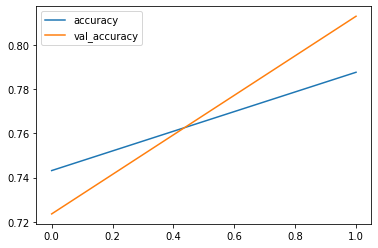

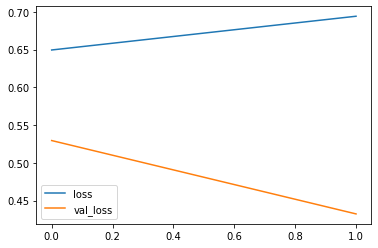

In [ ]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
model.evaluate(test_imgs, test_df) 

7/7 [==============================] - 7s 960ms/step - loss: 0.5245 - accuracy: 0.7427


[0.5244620442390442, 0.7427184581756592]

In [ ]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

16809984/16804768 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 6, 8, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/2
21/21 [==============================] - 205s 9s/step - loss: 0.7780 - accuracy: 0.4643 - val_loss: 0.5724 - val_accuracy: 0.7236
Epoch 2/2
21/21 [==============================] - 185s 8s/step - loss: 0.7178 - accuracy: 0.5344 - val_loss: 0.5733 - val_accuracy: 0.7967


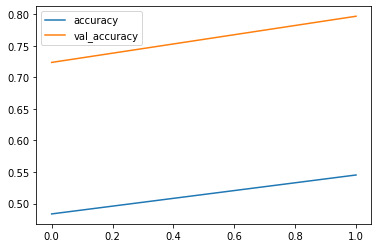

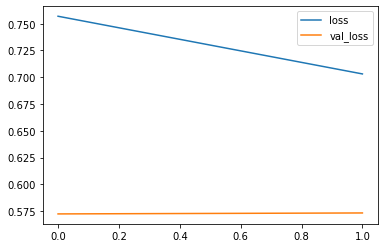

In [ ]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
model.evaluate(test_imgs, test_df)

7/7 [==============================] - 11s 2s/step - loss: 0.5468 - accuracy: 0.8010


[0.546797513961792, 0.8009708523750305]